In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [2]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['VIB']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2017-01-11,2.77,18.50,173442,3192131500,74728,1195641000,18.70,18.70,18.30,-0.20,-1.07
1,2017-01-13,2.28,15.20,70740,1083665000,49582,793312000,16.30,16.30,15.10,-1.90,-11.11
2,2017-01-16,2.29,15.30,134435,2040731000,147931,2366896000,15.40,15.40,14.90,0.00,0.00
3,2017-01-18,2.37,15.80,20408,320236800,53362,853792000,15.70,15.80,15.50,0.50,3.27
4,2017-01-20,2.38,15.90,52135,832843900,89126,1426016000,15.80,16.50,15.80,0.10,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...
1972,2024-12-17,19.20,19.20,3377700,64965000000,1,17950,19.35,19.35,19.20,-0.10,-0.52
1973,2024-12-13,19.25,19.25,5249600,100520000000,45000,846000000,19.10,19.25,19.05,0.15,0.79
1974,2024-12-18,19.15,19.15,5668900,108562000000,1,17900,19.20,19.25,19.05,-0.05,-0.26
1975,2024-12-19,18.90,18.90,12871900,244544000000,76364,1414836000,19.05,19.10,18.90,-0.25,-1.31


In [3]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               1977 non-null   object 
 1   GiaDieuChinh       1977 non-null   float64
 2   GiaDongCua         1977 non-null   float64
 3   KhoiLuongKhopLenh  1977 non-null   int64  
 4   GiaTriKhopLenh     1977 non-null   int64  
 5   KLThoaThuan        1977 non-null   int64  
 6   GtThoaThuan        1977 non-null   int64  
 7   GiaMoCua           1977 non-null   float64
 8   GiaCaoNhat         1977 non-null   float64
 9   GiaThapNhat        1977 non-null   float64
 10  ThayDoi_GiaTri     1977 non-null   float64
 11  ThayDoi_PhanTram   1977 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 185.5+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,1977.000000,1977.000000,1.977000e+03,1.977000e+03,1.977000e+03,1.977000e+03,1977.000000,1977.000000,1977.000000,1977.000000,1977.000000
mean,10.766500,25.583257,2.118364e+06,5.069952e+10,9.743542e+05,2.253776e+10,25.590592,26.002124,25.118574,0.001907,0.054977
std,6.611008,10.050676,3.117726e+06,6.740635e+10,8.171509e+06,1.543957e+11,10.033796,10.221346,9.867843,0.809680,2.370230
min,2.280000,12.700000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,12.900000,13.300000,12.400000,-17.400000,-26.730000
25%,4.230000,18.800000,2.374740e+05,5.201934e+09,0.000000e+00,0.000000e+00,18.800000,19.100000,18.500000,-0.200000,-0.860000
50%,10.960000,21.500000,1.040400e+06,2.939400e+10,0.000000e+00,0.000000e+00,21.550000,21.800000,21.350000,0.000000,0.000000
75%,16.900000,28.800000,2.739933e+06,7.028900e+10,3.900000e+04,8.237520e+08,28.700000,29.200000,28.000000,0.200000,1.030000
max,24.610000,74.000000,3.315770e+07,6.495430e+11,3.001000e+08,5.401950e+12,74.900000,75.900000,73.300000,4.200000,14.750000


In [4]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

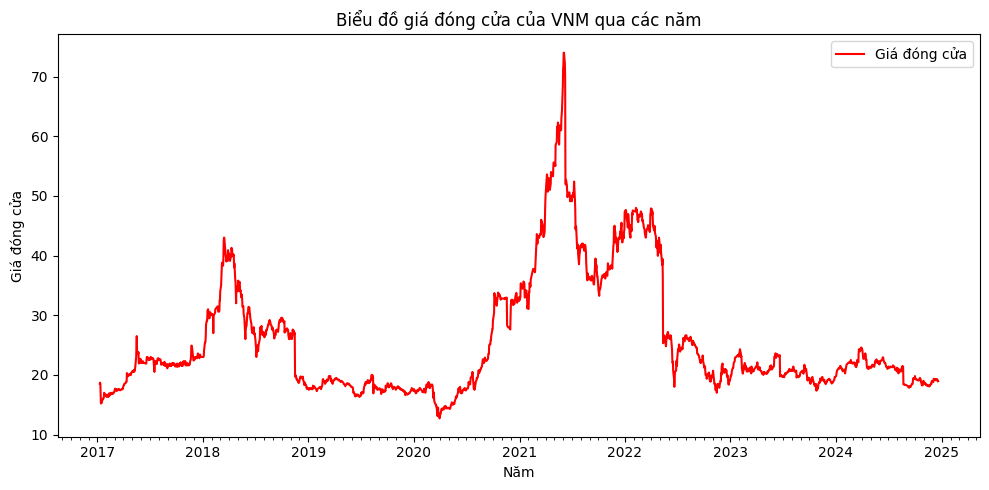

In [5]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [6]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [7]:
df1

,GiaDongCua
Ngay,
2017-01-09,18.50
2017-01-10,18.70
2017-01-11,18.50
2017-01-12,16.80
2017-01-13,15.20
...,...
2024-12-16,19.30
2024-12-17,19.20
2024-12-18,19.15


In [8]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [9]:
data

array([[18.5 ],
       [18.7 ],
       [18.5 ],
       ...,
       [19.15],
       [18.9 ],
       [18.95]])

In [10]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [11]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Epoch 1/100


C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.17609, saving model to save_models/VIB_model.keras
24/24 - 4s - 186ms/step - loss: 0.1761 - val_loss: 0.0897
Epoch 2/100

Epoch 2: loss improved from 0.17609 to 0.10557, saving model to save_models/VIB_model.keras
24/24 - 1s - 44ms/step - loss: 0.1056 - val_loss: 0.0846
Epoch 3/100

Epoch 3: loss improved from 0.10557 to 0.08855, saving model to save_models/VIB_model.keras
24/24 - 1s - 45ms/step - loss: 0.0886 - val_loss: 0.0590
Epoch 4/100

Epoch 4: loss improved from 0.08855 to 0.07679, saving model to save_models/VIB_model.keras
24/24 - 1s - 46ms/step - loss: 0.0768 - val_loss: 0.0484
Epoch 5/100

Epoch 5: loss improved from 0.07679 to 0.06747, saving model to save_models/VIB_model.keras
24/24 - 1s - 49ms/step - loss: 0.0675 - val_loss: 0.0489
Epoch 6/100

Epoch 6: loss improved from 0.06747 to 0.06020, saving model to save_models/VIB_model.keras
24/24 - 1s - 51ms/step - loss: 0.0602 - val_loss: 0.0411
Epoch 7/100

Epoch 7: loss improved from 0.

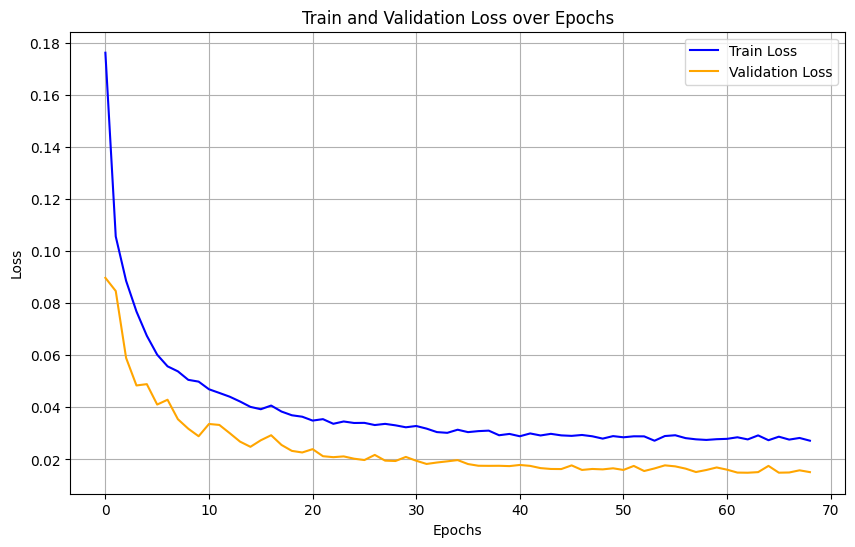

In [13]:
def build_model(input_shape):
    model = Sequential()
    
    # Giảm số đơn vị trong LSTM và tăng regularization
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True, 
                   kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=32, kernel_regularizer=l2(0.001)))
    
    # Tăng Dropout để giảm overfitting
    model.add(Dropout(0.5))
    
    # Lớp Dense để đưa ra kết quả dự đoán
    model.add(Dense(1))
    
    # Compile mô hình
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])
model = build_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/VIB_model.keras"

# Callbacks: ModelCheckpoint và EarlyStopping
callbacks = [
    ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='loss', patience=15, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình và lưu kết quả vào history
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
save_model_path = "models/VIB_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [18]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


In [19]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1500:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


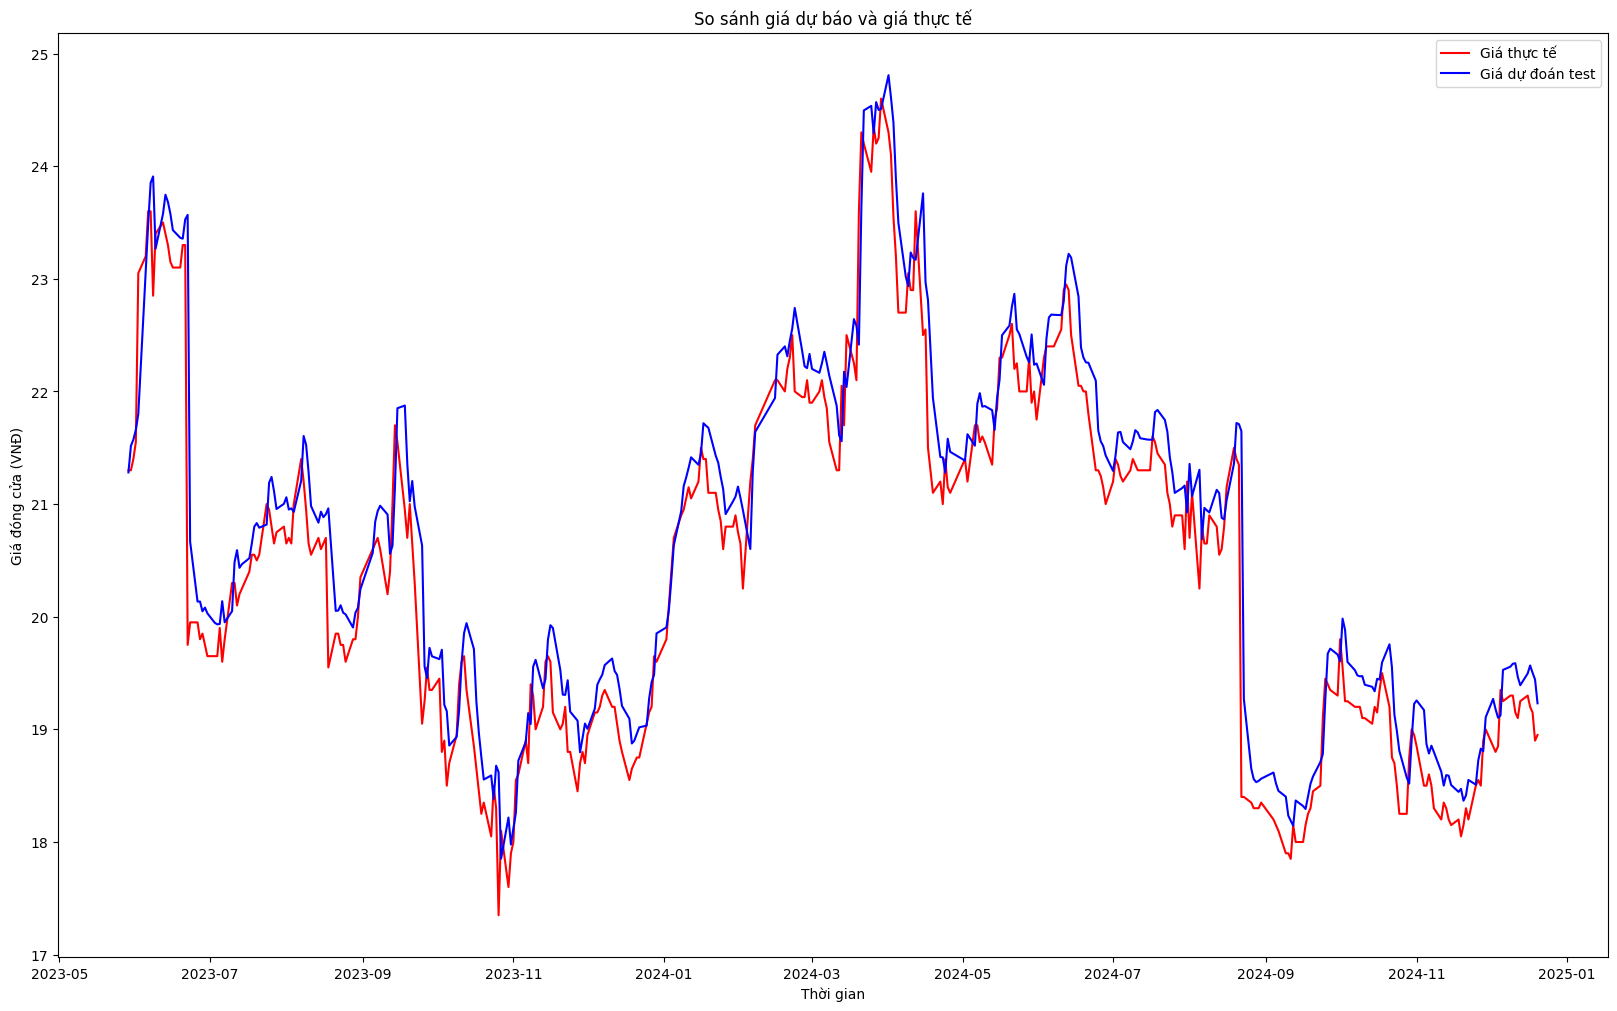

In [20]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [24]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9914992678297018
Sai số tuyệt đối trung bình trên tập train (VNĐ): 1.867849046335997
Phần trăm sai số tuyệt đối trung bình trên tập train: 4.397751530403986
RMSE trên tập train (VNĐ): 3.674415334478438
Độ chính xác trên tập train (%): 98.67588636595372
F1 Score trên tập train: 1.0
----------------------------------------------------


In [25]:
y_test = data[-len(y_test_predict):]

In [26]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9145062737255819
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.2093947453980443
Phần trăm sai số tuyệt đối trung bình trên tập test: 4.472514311291788
RMSE trên tập test (VNĐ): 1.397985887460749
Độ chính xác trên tập test (%): 95.07751448077201
F1 Score trên tập test: 1.0
----------------------------------------------------


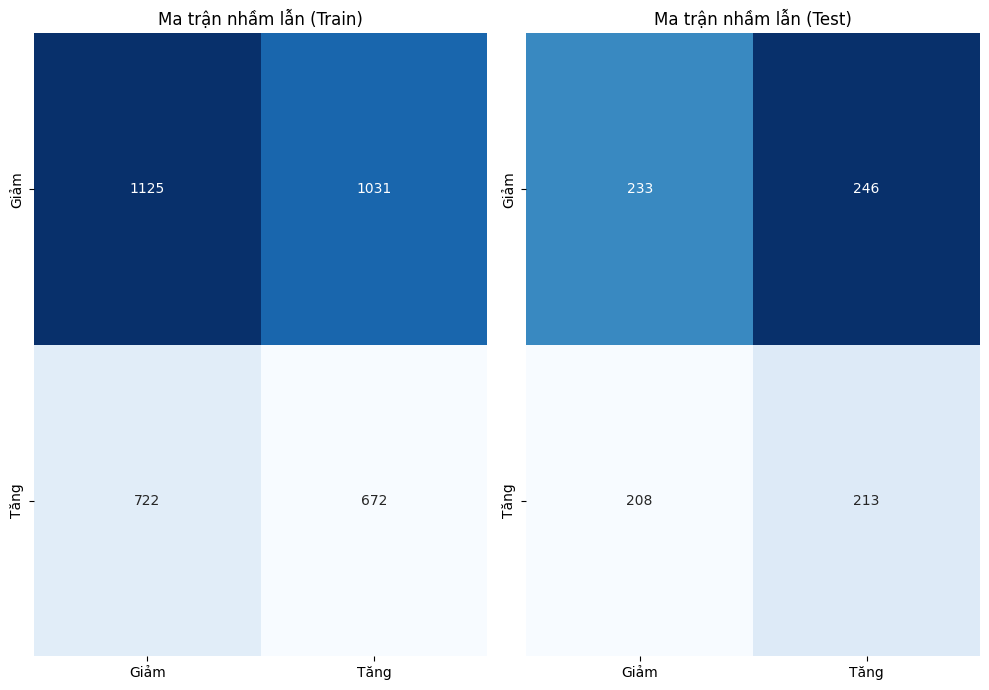

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_labels(data):
    return [1 if data[i] > data[i-1] else 0 for i in range(1, len(data))]

# Chuyển đổi giá trị thực tế và dự đoán thành nhãn phân loại
y_train_labels = create_labels(y_train)
y_train_predict_labels = create_labels(y_train_predict.flatten())

y_test_labels = create_labels(y_test)
y_test_predict_labels = create_labels(y_test_predict.flatten())

# Tạo ma trận nhầm lẫn cho tập train
cm_train = confusion_matrix(y_train_labels, y_train_predict_labels)
cm_test = confusion_matrix(y_test_labels, y_test_predict_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 7))

# Ma trận nhầm lẫn cho tập train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Train)")

# Ma trận nhầm lẫn cho tập test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Test)")

plt.tight_layout()
plt.show()